---
title: "Causal Inference of Labor Market Inequality Using PGM: A multidimensional analysis of unemployment rate and durations"
author:
    name: Mengjia Wei
    email: mw1296@georgetown.edu
    affiliation: Georgetown University
keywords:
  - PGM
  - Unemployment Rate
  - Unemployment Durations
  - Causal Inference
abstract: |
  This study investigates the causal relationships between age, occupation, race, and unemployment rates in the United States, applying probabilistic graphical modeling (PGM) to uncover latent dependency structures across demographic and industry variables. Using a PGM framework, we extend this approach to labor market data by constructing conditional dependence networks across two key dimensions: time (2015, 2024 and 2025) and group attributes (age, race, and industry). Specifically, the study examines recent college graduates (ages 22–24) relative to older individuals (25+), comparing their unemployment rates by major across 2024 and 2025. A second dimension of analysis focuses on industry-specific unemployment rate dynamics from 2015 to 2025, particularly in [retail], [arts], and [technology] sectors, and how these intersect with racial and age groups. In addition to rate-based measures, the study explores how unemployment duration has evolved between 2015 and 2025 across different occupations and age cohorts. This analysis seeks to identify whether certain groups—such as []—face longer or shorter periods of unemployment today compared to a decade ago, providing a more comprehensive view of labor market hardship. The model estimates the strength and direction of probabilistic dependencies using Bayesian structure learning algorithms, based on labor force aggregated data from BLS CPS datasets. The results indicate that recent college graduates in [] majors had a higher unemployment rate of [ ]% in 2025 H1 compared to [ ]% in 2024 H1. Additionally, the [retail], [arts], and [technology] industries experienced increased unemployment rates between 2015 and 2025, with respective changes of [ ], [ ], and [ ] percentage points. The findings also suggest that, consistent with earlier research, unemployment duration is negatively correlated with the unemployment rate by occupation, with industries exhibiting higher unemployment often associated with shorter average durations (Chien, Y., & Morris, P., 2016). The PGM framework reveals significant interactive effects between race and industry on unemployment, particularly among [e.g., Black or Hispanic workers] in the [e.g., retail or hospitality] sector. These findings contribute to the growing literature that leverages PGMs for social inference (e.g., Li et al., 2022), highlighting the model’s potential for uncovering structural labor inequalities over time and across population subgroups.
plain-language-summary: |
  TBD
key-points:
  - TBD
  - TBD
date: last-modified
bibliography: references.bib
citation:
  container-title: Georgetown Univeristy DSAN 5650 Journal
number-sections: true
jupyter: python3
---

## Introduction

The interplay of demographic characteristics and labor market dynamics consistently reveals significant disparities in unemployment rates. Decades of research reveal a persistent relationship between race, gender, and unemployment, evident across diverse economic cycles. Though the Black unemployment rate fell to a historic low of 6.1% in 2019, it was still twice as high as the White unemployment rate of 3.0%, as @ValerieWilson2022 observed. These disparities are further magnified at the intersection of race and gender. For instance, Black men faced a 6.1% unemployment rate in February 2024, notably higher than Black women at 4.4%. Similarly, Hispanic women's unemployment rate increased to 5.0% in February 2024, while Hispanic men experienced a decrease to 4.0% (@Joseph2024). Native American men also experienced higher unemployment (10%) than Native American women (7%) in 2022. Industry-specific analyses similarly highlight divergent unemployment trends. The Leisure and Hospitality sector reported the highest unemployment rate at 6.0% in 2024, an increase from 5.5% in 2023. Similarly, Wholesale and Retail Trade experienced elevated unemployment, reaching 4.7% in October 2024, up from 4.0% in 2023. Conversely, Financial Activities maintained a significantly lower unemployment rate of 1.9% (@Oberlo2024). 

Research from the U.S. Bureau of Labor Statistics consistently shows longer unemployment spells in sectors such as Manufacturing and Construction, while industries demanding specialized skills like Education and Health Services exhibit shorter durations. Study by @YiLiChienandPaulMorris reveals negative correlation between the unemployment rate and duration. Such variations in both the rate and duration of unemployment underscore complex interactions among race, gender, age, and industry.

@TOIEducation2025 published that the labor market for recent college graduates has "deteriorated noticeably" in the first quarter of 2025. The unemployment rate for this cohort (ages 22-27) ranged from 5.5% to 7.1%, exceeding the overall national average of 4.1-4.2%, with Anthropology (9.4%), Physics (7.8%), and Computer Engineering (7.5%) showing among the highest rates. 

![Unemployment Rate of Recent College Graduates](images/unemployment_rate_recent_graduate.png){#fig-graduates}

Although the Federal Open Market Committee (FOMC) reported a low overall unemployment rate for June 2025, recent data clearly indicate a noticeable uptick in the unemployment rate for the 22-27 age group since March, reaching 2021 levels and particularly affecting recent college graduates (@fig-graduates). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data pre-processing - part1: Merge several unemployment statistics excel files downlaoded from BLS webiste
import pandas as pd
import os
#os.getcwd()

def create_df_race(folder_path, demographic_type, id_vars, var_name, value_name):
    merged_df = pd.DataFrame()
    file_name = [f.removesuffix('.xlsx') for f in os.listdir(os.path.join("../data", folder_path)) if f.endswith('.xlsx')]
    for f in file_name:
        file_path = os.path.join("../data", folder_path, f + ".xlsx")    
        df = pd.read_excel(file_path)
        rows = df[df.iloc[:,0]=='Year'].index[0]+2-1
        df = pd.read_excel(file_path, skiprows=rows)
        df_long = df.melt(id_vars=id_vars, var_name=var_name, value_name=value_name)
        df_long[demographic_type] = f
        merged_df = pd.concat([merged_df, df_long], ignore_index=True)
    return merged_df

folder_path_list = ["unemployment_rate_by_race",
             "unemployment_rate_by_sex",
             "unemployment_rate_by_industry",
             "unemployment_rate_by_age",
            "unemployment_rate_by_education_attainment"]

demographic_type_list = ['Race',
                    'Sex',
                    'Industry',
                    'Age',
                    'Education_attainment']

d_vars="Year"
var_name="Month"
value_name="Unemployment_rate"

df_dic = {}
for i in range(0, len(folder_path_list)):
    folder_path = folder_path_list[i]
    demographic_type=demographic_type_list[i]
    merged_df = create_df_race(folder_path, demographic_type, "Year", "Month", "Unemployment_rate")
    df_dic[demographic_type] = merged_df

#list(df_dic.values())[0]

In [3]:
# Data pre-processing - part2: Load and process monthly unemployment overall file
df_overall = pd.read_excel("../data/unemployment_rate_monthly_data.xlsx", skiprows=11)
df_overall_long = df_overall.melt(id_vars="Year", var_name="Month", value_name="Unemployment_rate")

In [4]:
#| label: tbl-survey-data
#| tbl-cap: BLS June 2025 Labor Force Survey Data

# Data pre-processing - part3: Load and process Jun 2025 BLS labor survey data
# process the survey data
import numpy as np
df_survey_jun = pd.read_csv("../data/survey_data/jun_2025.csv")
df_survey_jun.columns= ["sex","education_attainment","race","age","employment_status",
                        "unmployment_duration","industry","occupation","industry_detailed",
                        "occupation_detailed",'geo_code']
## create mapping tables to convert the demographic codes to the descriptions
sex_mapping = {
        1: "male",
        2: "female"
}

education_attainment_codes = list(np.arange(31,47))
education_attainment_values = [
        'less_than_high_school',
		'less_than_high_school',
		'less_than_high_school',
        'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'less_than_high_school',
'high_school',
'some_college_or_associate_degree',
'some_college_or_associate_degree',
'some_college_or_associate_degree',
'bachelors_degree',
'masters_degree',
'professional_degree',
'doctoral_degree'
    ]    
education_attainment_mapping=dict(zip(education_attainment_codes,education_attainment_values))

race_codes = list(np.arange(1,27))
race_values = [
        "white",
        "black",
        "other",
        "asian"
    ] + ["other"] * 22
race_mapping= dict(zip(race_codes, race_values))


employment_status_codes =[
        1,2,3,4,5,6,7
    ]
employment_status_names = [
        "employed",
        "employed",
        "unemployed",
        "unemployed",
        "not in labor force",
        "not in labor force",
        "not in labor force"
    ]
employment_status_mapping = dict(zip(employment_status_codes,employment_status_names))

industry_codes = list(np.arange(1,15))
industry_names = [
    "Agriculture, forestry, fishing, and hunting",
    "Mining",
    "Construction",
    "Manufacturing",
    "Wholesale and retail trade",
    "Transportation and utilities",
    "Information",
    "Financial activities",
    "Professional and business services",
    "Educational and health services",
    "Leisure and hospitality",
    "Other services",
    "Public administration",
    "Armed Forces"
    ]
industry_mapping = dict(zip(industry_codes, industry_names))

## Create new columns with decoded names
df_survey_jun['sex_name'] = df_survey_jun['sex'].map(sex_mapping)
df_survey_jun['race_name'] = df_survey_jun['race'].map(race_mapping)
df_survey_jun['education_attainment_name'] = df_survey_jun['education_attainment'].map(education_attainment_mapping)
df_survey_jun['employment_status_name'] = df_survey_jun['employment_status'].map(employment_status_mapping)
df_survey_jun['industry_name'] = df_survey_jun['industry'].map(industry_mapping)

## Filter out industry_name na rows
df_survey_jun = df_survey_jun[~df_survey_jun['industry_name'].isna()]

## Display the table
display(df_survey_jun.filter(like = "name", axis=1).head(10).style.hide(axis = "index"))

sex_name,race_name,education_attainment_name,employment_status_name,industry_name
male,white,bachelors_degree,employed,Construction
male,white,high_school,employed,Construction
female,white,bachelors_degree,employed,Manufacturing
male,white,bachelors_degree,employed,Manufacturing
female,white,masters_degree,employed,Transportation and utilities
female,white,bachelors_degree,employed,Construction
male,white,high_school,employed,Wholesale and retail trade
female,white,bachelors_degree,employed,Professional and business services
male,white,less_than_high_school,employed,Professional and business services
female,white,high_school,employed,Educational and health services


Data from the U.S. Bureau of Labor Statistics (BLS) June 2025 labor force survey provide individual-level employment status and corresponding demographic information. For the purpose of this study, a subset of these relevant columns is utilized (@tbl-survey-data). 


## EDA
### Unemployment Rates of Differenet Demographics

Unemployment Rate Distribution Histograms By Race


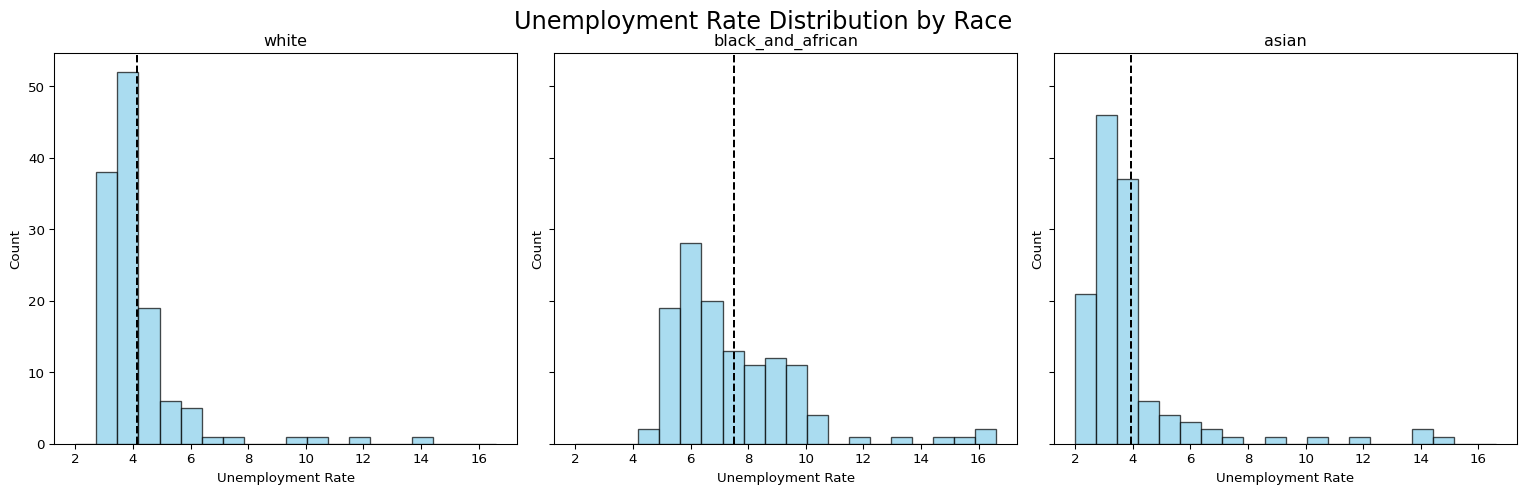

Unemployment Rate Distribution Histograms By Sex


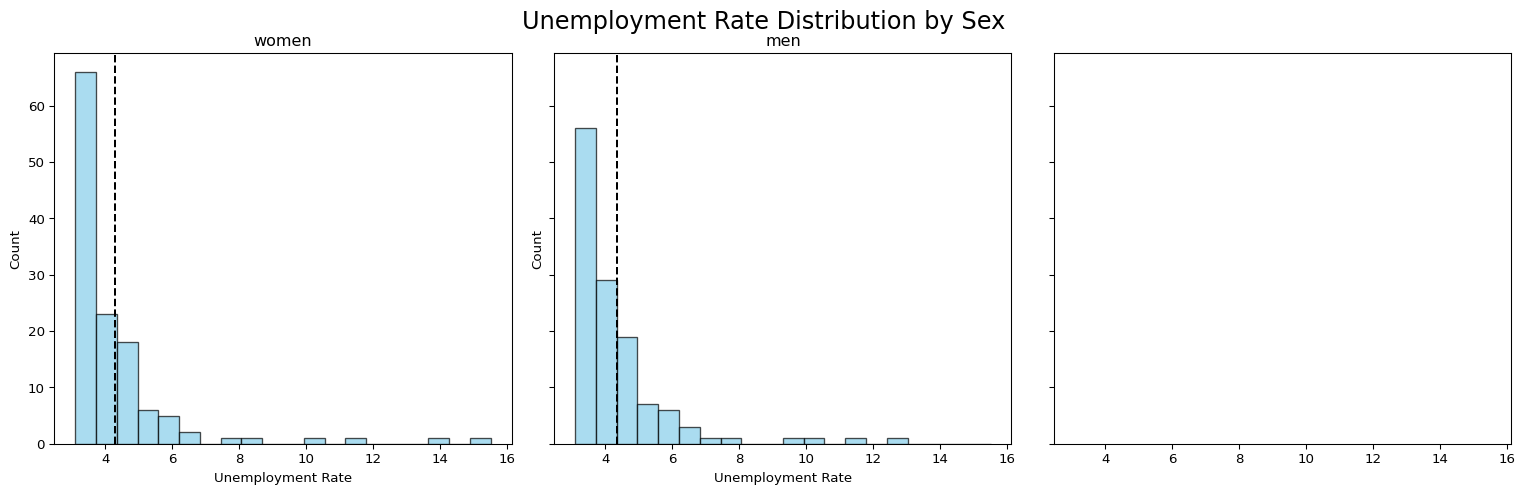

Unemployment Rate Distribution Histograms By Industry


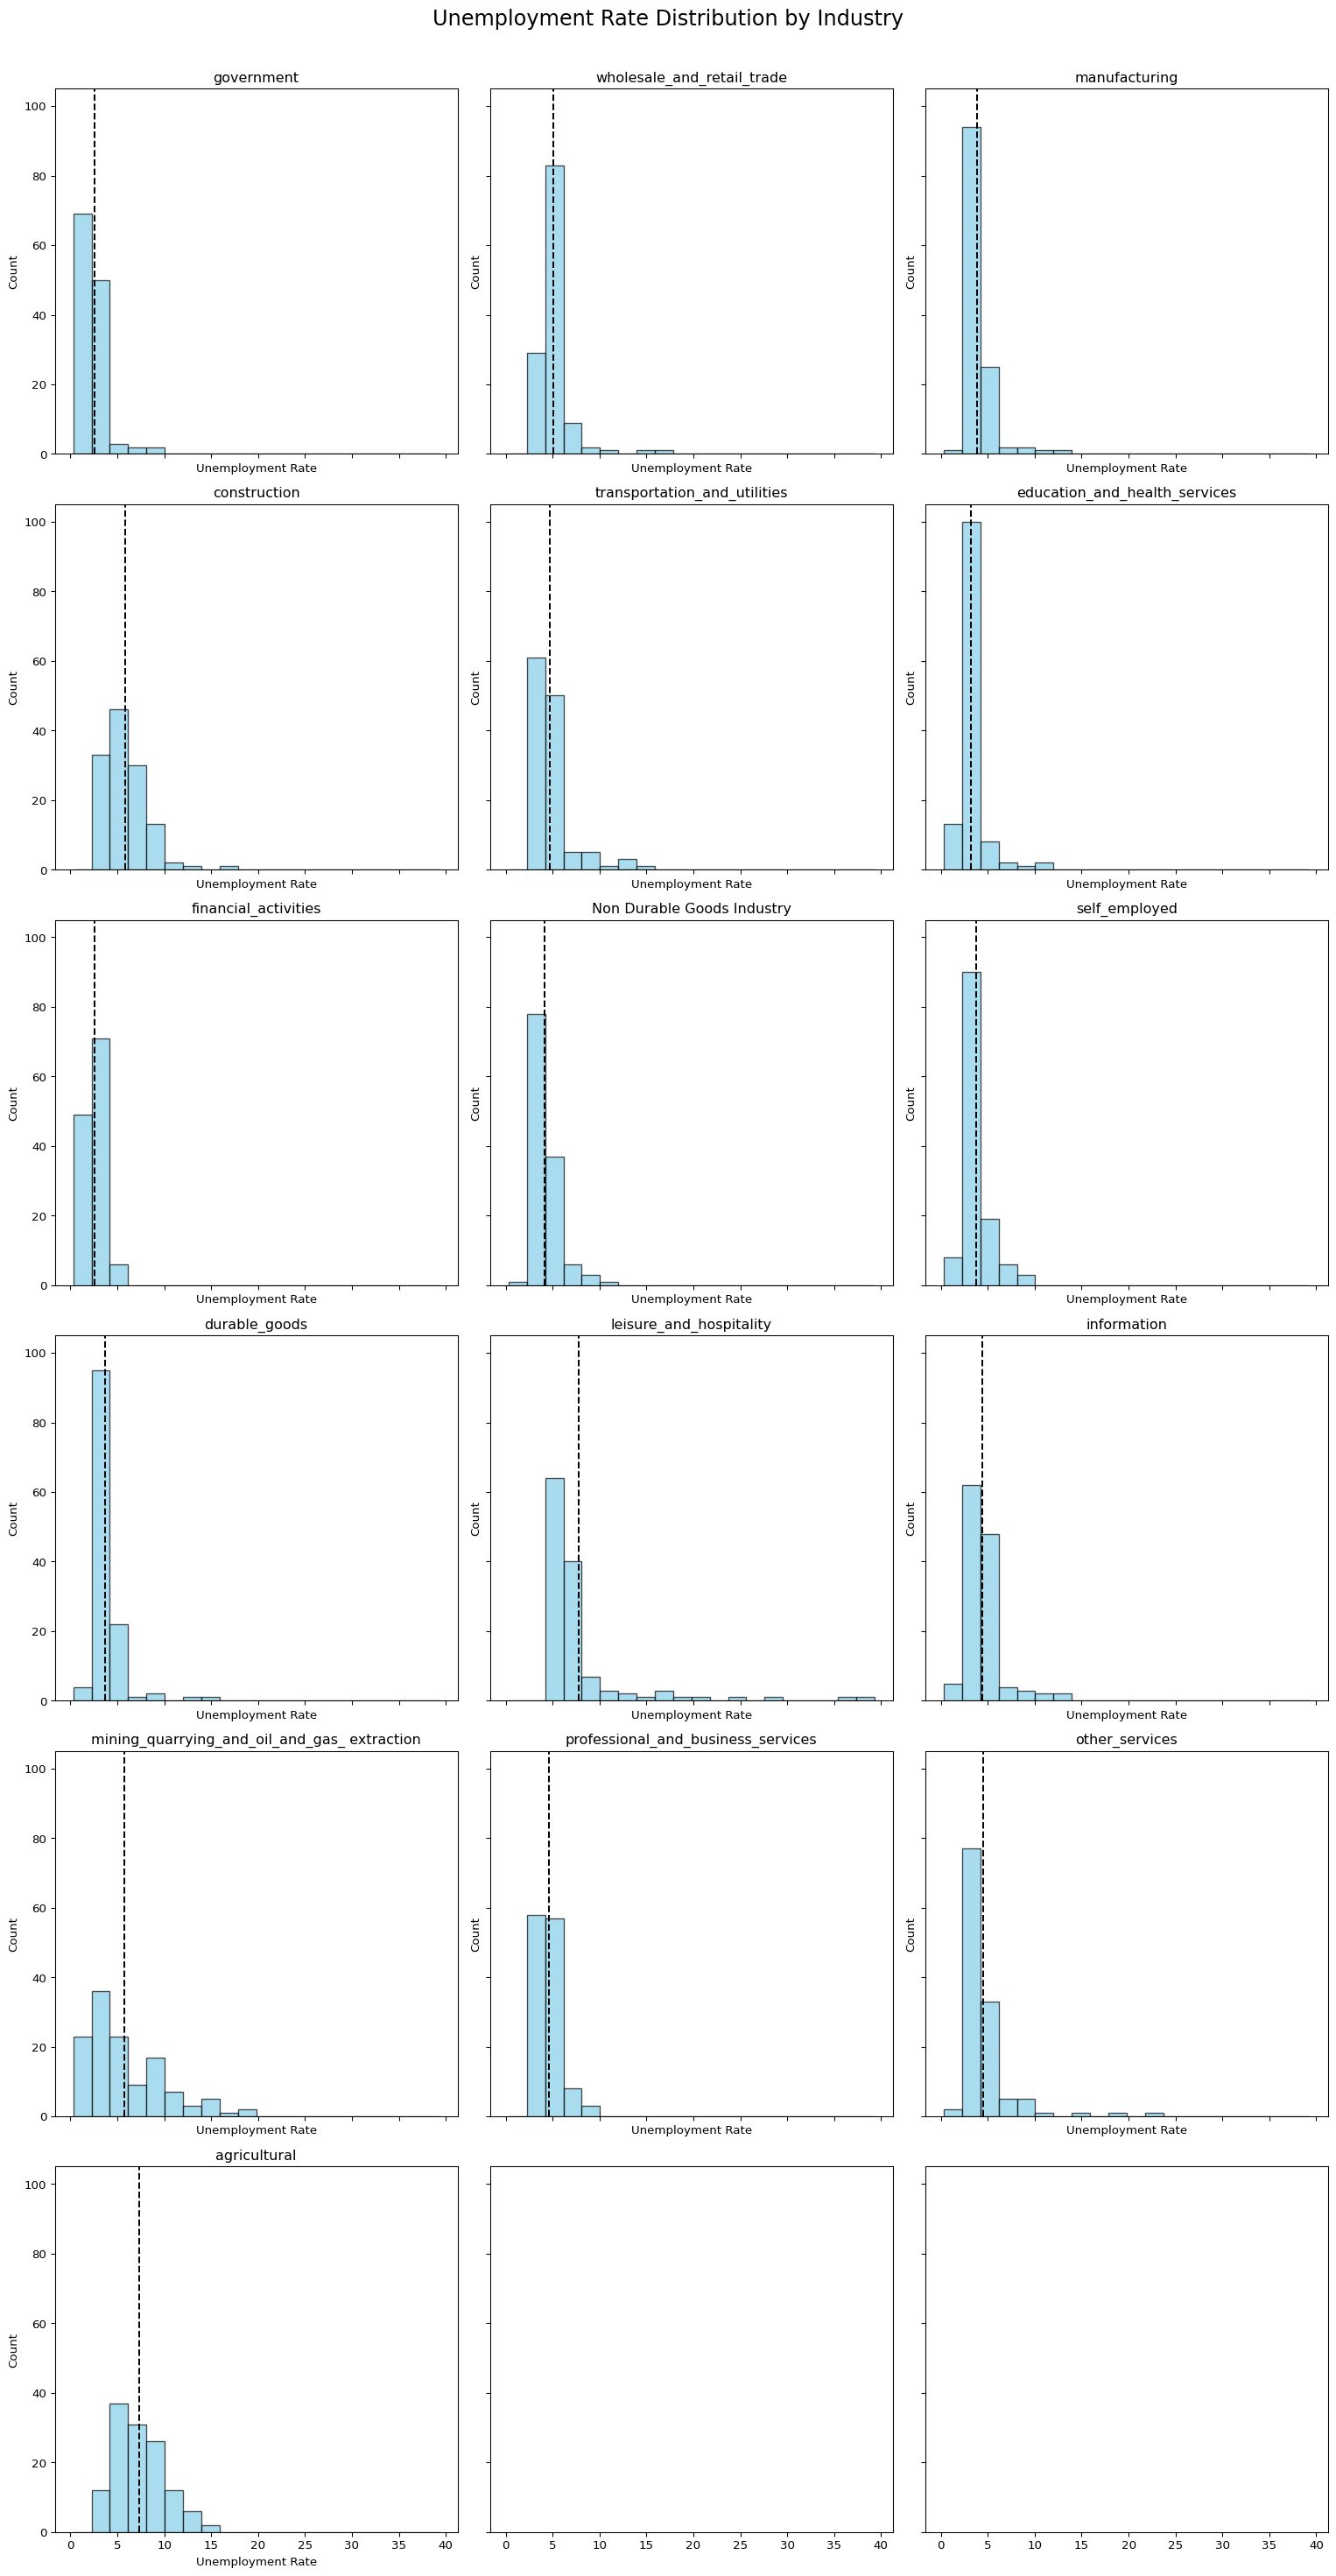

Unemployment Rate Distribution Histograms By Age


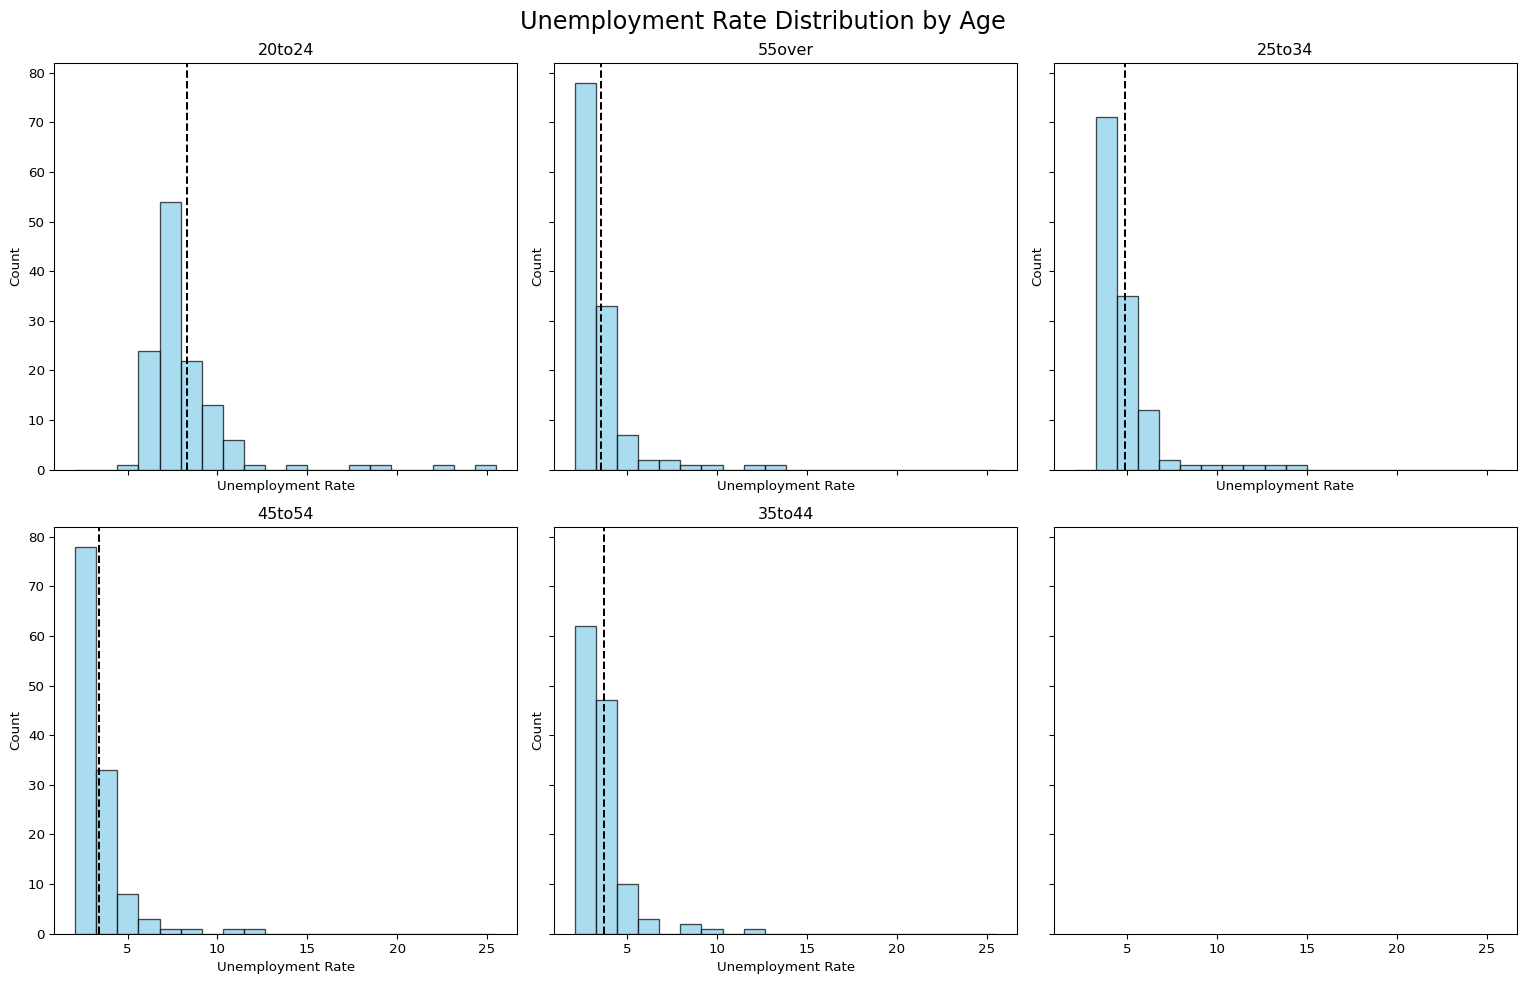

In [5]:
# Plot the distributions of unemployment stats of different demographic categories 

## 1. Plot the umemployment rate distributions by gender, age, industry, education_unattainment
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(df_plot, demographic_type):
    unique_categories = df_plot[demographic_type].unique()
    num_unique_categories = len(unique_categories)
    ncol = 3
    nrow = np.int64(np.ceil(num_unique_categories/ncol))
    fig, axes = plt.subplots(ncols=ncol, nrows=nrow, sharex=True, sharey=True, figsize = (16,nrow*5))
    axes = axes.flatten()
    min_rate = df_plot['Unemployment_rate'].min()
    max_rate = df_plot['Unemployment_rate'].max()
    num_bins = 20 
    bins = np.linspace(min_rate, max_rate, num_bins + 1)
    for i, category in enumerate(unique_categories):
        ax = axes[i]
        vals = df_plot[df_plot[demographic_type]==category]['Unemployment_rate']
        ax.hist(vals, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        ax.axvline(np.mean(vals), color = 'black', linestyle = "--")
        ax.set_title(category, fontsize=12)
        ax.set_xlabel('Unemployment Rate', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
    plt.tight_layout()
    plt.suptitle(f'Unemployment Rate Distribution by {demographic_type}', y=1.02, fontsize=18) 
    plt.show()

# Show the graphs except for the last one in order to add the ariticle label to the last grapph
for i in range(0, len(df_dic.keys())-1):
    df_plot = list(df_dic.values())[i]
    demographic_type = list(df_dic.keys())[i]
    print(f"Unemployment Rate Distribution Histograms By {demographic_type}")
    plot_hist(df_plot, demographic_type)


Unemployment Rate Distribution Histograms By Education_attainment


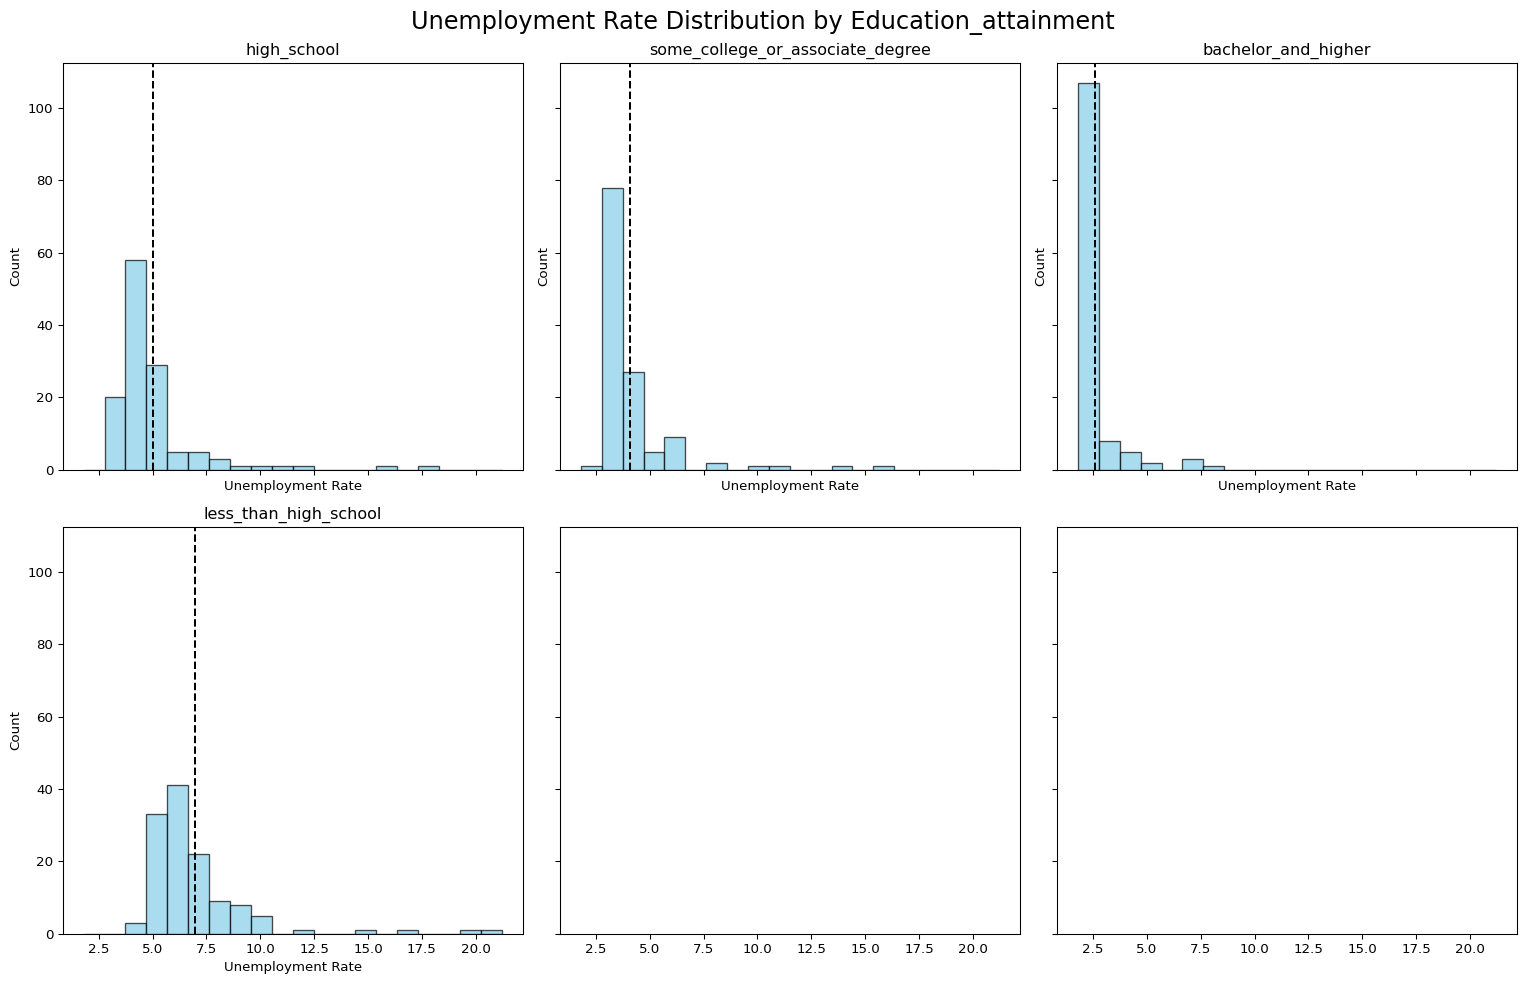

In [6]:
#| label: fig-histogram-unemployment-rate-demographics
#| fig-cap: Unemployment Rate Distributions By Demographics (2015-2025 statistics)
#| fig-alt: Histogram plots of the unemployment rate distributins by Age, Sex, Race, Industry and Education Attainment using 2015-2025 BLS data

## 2. Plot the overall umemployment rate 
## Display this graph separately from the preious chuck in order to add the aritcle label
df_plot = list(df_dic.values())[len(df_dic.keys())-1]
demographic_type = list(df_dic.keys())[len(df_dic.keys())-1]
print(f"Unemployment Rate Distribution Histograms By {demographic_type}")
plot_hist(df_plot, demographic_type)

BLS data from 2015–2025 indicate that the Black or African American population experienced the highest average unemployment rate (7.5%), primarily within the 5–10% range. Gender differences are minimal, with both averaging around 5%, though rates are slightly higher for men. Among industries, Leisure and Hospitality recorded the highest unemployment (10%) with a long-tail distribution, followed by Agriculture (5–11%) and moderate variability. Construction and Mining/Oil & Gas exhibit similar but marginally lower patterns. The 22–24 age group stands out with significantly elevated unemployment—averaging 7% and predominantly above 5%—while other age groups display lower and more uniform rates. Financial Activities show the lowest and most stable unemployment, consistently under 5%. Individuals without a high school diploma face high and variable unemployment, averaging 7% with a long-tail skew. These patterns suggest that young adults (22–24), Black or African Americans without college degrees, and those employed in Leisure, Construction, or Mining sectors are disproportionately affected by higher unemployment. (@fig-histogram-unemployment-rate-demographics).

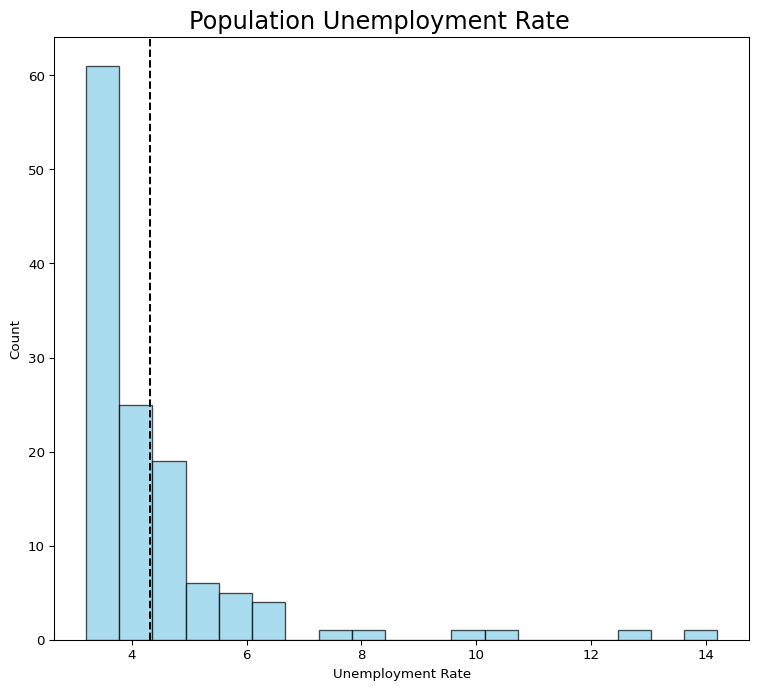

In [7]:
#| label: fig-histogram-unemployment-rate
#| fig-cap: Overall Population Unemployment Rate Distributions (2015-2025 statistics)
#| fig-alt: Histogram plot of the overall population unemployment rate distributins using 2015-2025 BLS data
min_rate = df_overall_long['Unemployment_rate'].min()
max_rate = df_overall_long['Unemployment_rate'].max()
num_bins = 20
bins = np.linspace(min_rate, max_rate, num_bins)
fig, ax = plt.subplots(figsize = (8, 7))
ax.hist(df_overall_long['Unemployment_rate'], bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(np.mean(df_overall_long['Unemployment_rate']), color="black", linestyle="--")
ax.set_xlabel("Unemployment Rate", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
plt.tight_layout()
plt.suptitle("Population Unemployment Rate", y =1.02, fontsize=18)
plt.show()

According to BLS data from 2015–2025, the overall population unemployment rate averaged slightly above 4%, with the majority of observations concentrated between 2% and 5% and exhibiting relatively low variability (@fig-histogram-unemployment-rate).

## PGM
We posit that unemployment vulnerability is driven by structural inequalities within the labor market, particularly those rooted in demographic and industrial dimensions. Demographic disparities are represented by variables such as race, age, and educational attainment and industry; sex is excluded from the analysis due to prior findings indicating minimal impact on unemployment rates. Establishing a baseline unemployment level is a necessary step before assessing the marginal effects of these demographic and industrial factors.

### Baseline unemployment rate distribution 
Figure 3 illustrates that the population unemployment rate is right-skewed, suggesting that the Log-Normal distribution is an appropriate model. We are going to estimate the parameters of a Log-Normal distribution from the population distribution data using MLE. ($\sigma$, $\text{loc}$, and $\text{scale}$).


Fitted Log-Norm Distribution Parameters:
  Shape parameter 'alpha'): 9.92
  Location parameter (loc): 3.20
  Scale parameter (scale): 0.03


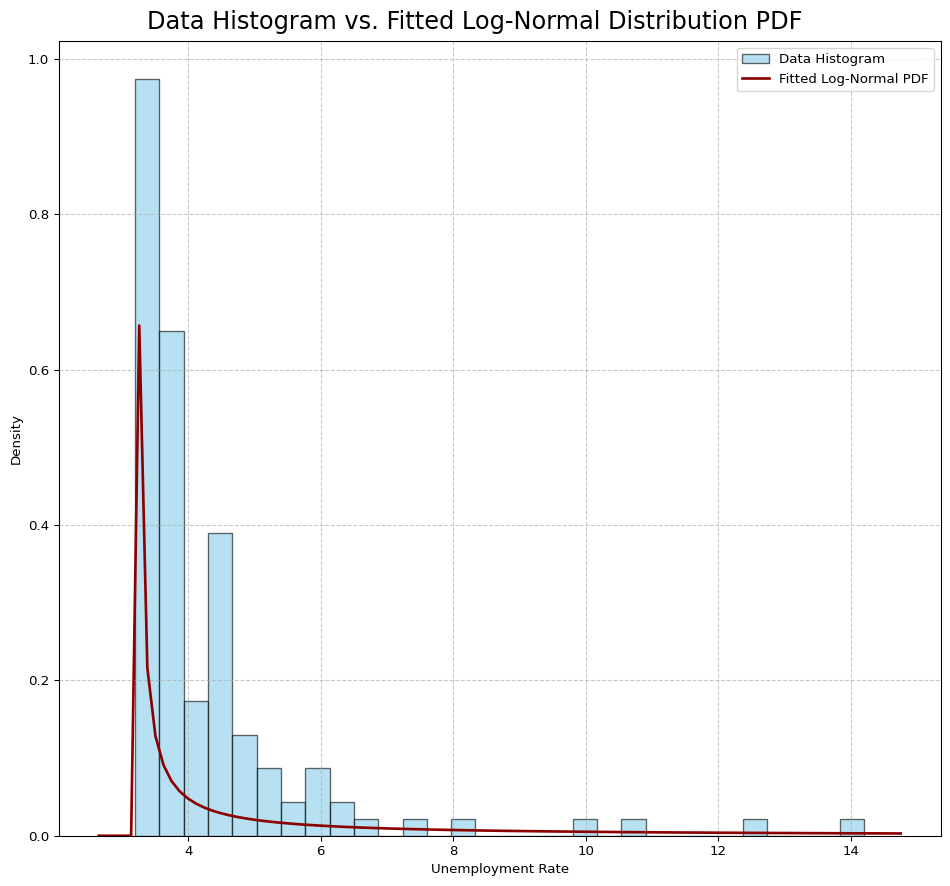

In [8]:
#| label: fig-histogram-lognorm
#| fig-cap: Unmployment Rate Histogram vs. Fitted Log-Norm PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted log-norm distribution.

# Fit log-norm distribution using population unemployment rate data
from scipy.stats import lognorm, kstest, skew 

## Get the unemployment_rate data that is not NA, convert to array
data_to_fit = df_overall_long[~np.isnan(np.array(df_overall_long['Unemployment_rate']))]['Unemployment_rate']

sigma_fit, loc_fit, scale_fit = lognorm.fit(data_to_fit) # Fit log-normal distribution

# Print the estimated parameters
print(f"\nFitted Log-Norm Distribution Parameters:")
print(f"  Shape parameter 'alpha'): {sigma_fit:.2f}")
print(f"  Location parameter (loc): {loc_fit:.2f}")
print(f"  Scale parameter (scale): {scale_fit:.2f}")

# Visualize the fit
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Data Histogram')
## Fitted log-norm pdf
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Log-Normal PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Log-Normal Distribution PDF", y=1.02, fontsize=18)
plt.show()

By overlaying the smooth PDF curve on top of original data's histogram, we can visualize that the Log-Normal distribution matches the distribution of the actual data. The peak of the PDF align with the peak of the histogram. The spread of the PDF roughly match the spread of the data, including the tail (@fig-histogram-lognorm).
Now we need to use Kolmogorov-Smirnov Test to test Goodness-of-fit with the original data and estimated parameters, then examine the p value. 

In [9]:
# KS goodness of fit test
d_statistic, p_value = kstest(data_to_fit, lambda x: lognorm.cdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)) 
print(f"\nKolmogorov-Smirnov Test Results:")
print(f"  D-statistic: {d_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")


Kolmogorov-Smirnov Test Results:
  D-statistic: 0.4592
  P-value: 0.0000


With $p$-value < 0.05, we can't reject the hypothesis that the distribution does not come from the Log-Normal distribution, suggesting Log-Normal is not a good fit for the data. Next, explore other right-skewed distributions - Gamma distribution or the Weibull distribution.


Fitted Gamma Distribution Parameters:
  Shape parameter 'alpha': 0.45
  Location parameter 'loc': 3.20
  Scale parameter 'scale'): 1.36


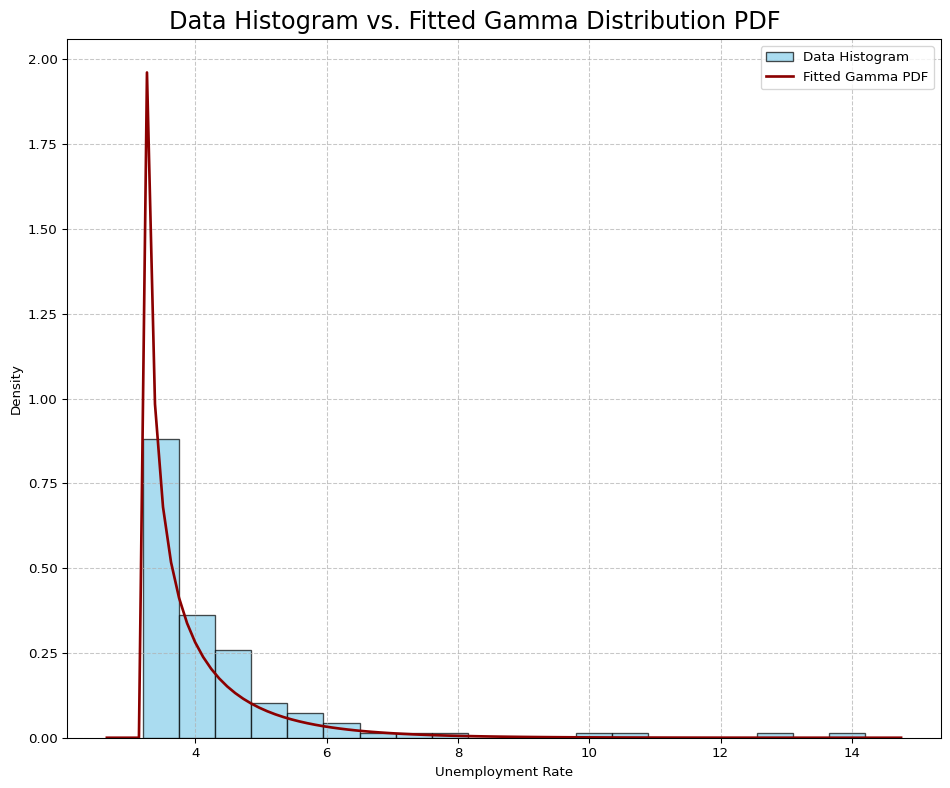

In [10]:
#| label: fig-histogram-gamma
#| fig-cap: Unmployment Rate Histogram vs. Fitted Gamma PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted Gamma distribution.

# Fit gamma distribution using MLE
from scipy.stats import gamma, skew, kstest
alpha_fit, loc_fit, scale_fit = gamma.fit(data_to_fit) # fit gamma distribution

# Print the estimated parameters
print(f"\nFitted Gamma Distribution Parameters:")
print(f"  Shape parameter 'alpha': {alpha_fit:.2f}")
print(f"  Location parameter 'loc': {loc_fit:.2f}")
print(f"  Scale parameter 'scale'): {scale_fit:.2f}")

# Visualize the fit
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins = 20, density=True, color='skyblue', alpha= 0.7, edgecolor='black', label = 'Data Histogram')
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)

## Plot fitted gamma pdf
p = gamma.pdf(x, alpha_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Gamma PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Gamma Distribution PDF", y=1.02, fontsize=18)
plt.show()

Although visually the Gamma distribution matches the shape and spread of the actual data. (@fig-histogram-gamma), we need to
use KS Test to test Goodness-of-fit by examining the p value. 

In [11]:
# Fit the gamma 
d_statistic, p_value = kstest(data_to_fit, lambda x: gamma.cdf(x, alpha_fit, loc=loc_fit, scale=scale_fit))
print(f"\nKolmogorov-Smirnov Test Results:")
print(f"  D-statistic: {d_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")


Kolmogorov-Smirnov Test Results:
  D-statistic: 0.2699
  P-value: 0.0000


Again, with $p$-value < 0.05, we can not confidently say that the data comes from the Gamma distribution. Next, explore Weibull distribution.

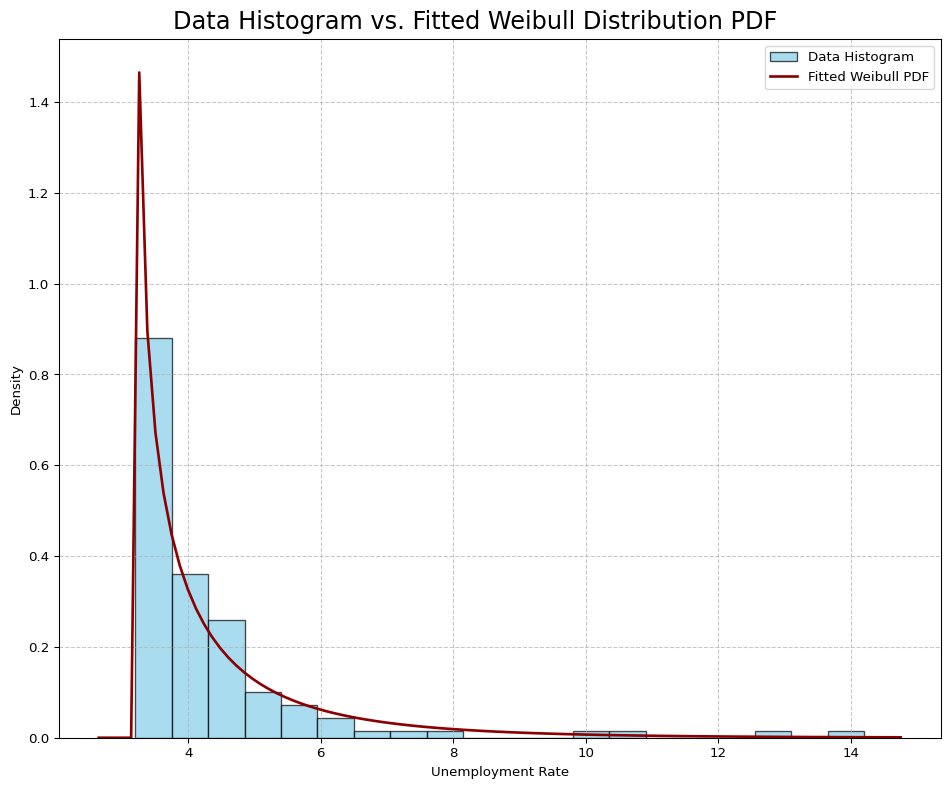

In [12]:
#| label: fig-histogram-weibull
#| fig-cap: Unmployment Rate Histogram vs. Fitted Weibull PDF
#| fig-alt: Plot the histogram of unemployment rate data and overlay the Probability Density Function (PDF) of the fitted Weibull distribution.

# Fit Weibull distribution using MLE
from scipy.stats import weibull_min, skew, kstest
from scipy.special import gamma as gamma_func # For Weibull mean calculation
c_fit, loc_fit, scale_fit = weibull_min.fit(data_to_fit) # fit weibull distribution

# Print the estimated parameters
# print(f"\nFitted Weibull Distribution Parameters:")
# print(f"  Shape parameter 'c' (k): {c_fit:.4f}")
# print(f"  Location parameter (loc): {loc_fit:.4f}")
# print(f"  Scale parameter (scale, lambda): {scale_fit:.4f}")

# Visualize the fit
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
## Histogram of the unemployment data
ax.hist(data_to_fit, bins = 20, density=True, color='skyblue', alpha= 0.7, edgecolor='black', label = 'Data Histogram')
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)

## Plot fitted gamma pdf
p = weibull_min.pdf(x, c_fit, loc=loc_fit, scale=scale_fit)
ax.plot(x, p, 'darkred', lw=2, label='Fitted Weibull PDF')
ax.set_xlabel('Unemployment Rate', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Data Histogram vs. Fitted Weibull Distribution PDF", y=1.02, fontsize=18)
plt.show()

In [13]:
# Fit the Weibull
d_statistic, p_value = kstest(data_to_fit, lambda x: weibull_min.cdf(x, c_fit, loc=loc_fit, scale=scale_fit))
# Calculate inferred mean
fitted_mean = loc_fit + scale_fit * gamma_func(1 + 1/c_fit)
# print(f"\nKolmogorov-Smirnov Test Results:")
# print(f"  D-statistic: {d_statistic:.4f}")
# print(f"  P-value: {p_value:.4f}")

In [14]:
#| label: tbl-weibull-params
#| tbl-cap: Weibull Distribution and Fitness Statistics

# Print out the Weibull stats
weibull_stats = {
  "Parameters": [
    "Shape (c)",
    "Location (loc)" ,
    "Scale",
    "D_statistics",
    "P-value",
    "Fitted Mean"
  ],
  "Values": [
     round(c_fit, 4),
     round(loc_fit, 4),
     round(scale_fit, 4),
     round(d_statistic, 4),
     round(p_value, 4),
     round(fitted_mean, 2)
  ]
}
weibull_stats_table = pd.DataFrame(weibull_stats)
display(weibull_stats_table.style.hide(axis="index"))

Parameters,Values
Shape (c),0.709300
Location (loc),3.200000
Scale,0.920400
D_statistics,0.104700
P-value,0.117300
Fitted Mean,4.350000


The overlayed smooth PDF curve on top of original data's histogram @fig-histogram-weibull suggests that the Weibull distribution matches the distribution of the actual data. The results of the Weibull distribution, summarized in Table @tbl-weibull-params, including the shape, location, and scale parameters, along with the D-statistic, P-value, and fitted mean also proves Weibull distribution is a good fit, supported by a KS test p-value of 0.1173 (greater than 0.05). The estimated parameters (c=0.7093, loc=3.2000, scale=0.9204) align well with the spread of the data. Shape (c<1): Confirms the strong right-skewness of the data. Location (loc=3.2000): Indicates the distribution starts around 3.20, matching data's lower bound. Inferred Mean: The calculated mean of approximately 4.35 from these parameters is close but slightly higher than the data's actual mean of around 4, showing a good capture of central tendency.

### Define the fixed Baseline
```python
weibull_fitted_mean_prob = 0.0435
# Convert the fitted mean probability to its log-odds equivalent in order to model binary outcome with logistic regression
fixed_baseline_log_odds = np.log(weibull_fitted_mean_prob / (1 - weibull_fitted_mean_prob))
```

In [15]:
weibull_fitted_mean_prob = 0.0435
# Convert the fitted mean probability to its log-odds equivalent in order to model binary outcome with logistic regression
fixed_baseline_log_odds = np.log(weibull_fitted_mean_prob / (1 - weibull_fitted_mean_prob))

### Define the PyMC model
This section sets up the Bayesian model to estimate the additive race effect relative to the fixed baseline.
```python
```

In [16]:
# import pymc as pm

# with pm.Model() as race_effect:
#     # Prior for the race effect (beta_race)
#     beta_race = pm.Normal('beta_race', mu=0, sigma=1)

#     # Expected log-odds of unemployment for each observed individual: baselline_log_odds + race_effect
#     expected_logit_unemployment = fixed_baseline_log_odds + beta_race * data['is_black_african'].values

#     # Transform log-odds back to probability using the inverse logit function
#     p_unemployment = pm.Deterministic('p_unemployment', pm.math.invlogit(expected_logit_unemployment))

#     # Likelihood function for binary outcomes from Bernoulli distribution
#     unemployment_status_observed = pm.Bernoulli(
#         'unemployment_status_observed',
#         p=p_unemployment, # Model's predicted probability of unemployment for each individual
#         observed=data['unemployment_status'].values # Actual observed employment status outcome
#     )

```python
# import pymc as pm

# with pm.Model() as race_effect:
#     # Prior for the race effect (beta_race)
#     beta_race = pm.Normal('beta_race', mu=0, sigma=1)

#     # Expected log-odds of unemployment for each observed individual: baselline_log_odds + race_effect
#     expected_logit_unemployment = fixed_baseline_log_odds + beta_race * data['is_black_african'].values

#     # Transform log-odds back to probability using the inverse logit function
#     p_unemployment = pm.Deterministic('p_unemployment', pm.math.invlogit(expected_logit_unemployment))

#     # Likelihood function for binary outcomes from Bernoulli distribution
#     unemployment_status_observed = pm.Bernoulli(
#         'unemployment_status_observed',
#         p=p_unemployment, # Model's predicted probability of unemployment for each individual
#         observed=data['unemployment_status'].values # Actual observed employment status outcome
#     )
```

In [17]:
# Create variable "baseline" as baseline level of unemployment rate

# Create variable - unemployment_vulnerability 
# unemployment_vulnerability = pm.math.invlogit(
#         baseline # baseline unemployment rate
#         + race_effect[race]
#         + age_effect[age]
#         + education_effect[education_attainment]
#         + industry_effect[industry]
#     )

In [18]:
import matplotlib.pyplot as plt
import numpy as np
eruptions = [1492, 1585, 1646, 1677, 1712, 1949, 1971, 2021]

$$
p(x) = \frac{e^{-\lambda} \lambda^{x}}{x !}
$$ {#eq-poisson}

where $\lambda$ is the rate of eruptions per year. Using @eq-poisson, the probability of an eruption in the next $t$ years can be calculated.

| Name                | Year |
|---------------------|------|
| Current             | 2021 |
| Teneguía            | 1971 |
| Nambroque           | 1949 |
| El Charco           | 1712 |
| Volcán San Antonio  | 1677 |
| Volcán San Martin   | 1646 |
| Tajuya near El Paso | 1585 |
| Montaña Quemada     | 1492 |

: Recent historic eruptions on La Palma {#tbl-history}

@tbl-history summarises the eruptions recorded since the colonization of the islands by Europeans in the late 1400s.

![Map of La Palma](images/la-palma-map.png){#fig-map}

La Palma is one of the west most islands in the Volcanic Archipelago of the Canary Islands (@fig-map).

{{< embed notebooks/data-screening.qmd#fig-spatial-plot >}}

@fig-spatial-plot shows the location of recent Earthquakes on La Palma.

Data and methods are discussed in @sec-data-methods.

Let $x$ denote the number of eruptions in a year. Then, $x$ can be modeled by a Poisson distribution

## Data & Methods {#sec-data-methods}

## Conclusion

## References {.unnumbered}

::: {#refs}
:::